In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#1
def mean_vector(data):
    ones=pd.DataFrame({'ones': np.ones(len(data))})
    mean=ones.transpose().dot(data)/len(data)
    return mean

def covariance_matrix(data):
    mean=mean_vector(data)
    mean_rep = pd.concat([mean]*len(data))
    mean_rep.columns=data.columns
    mean_rep.reset_index(inplace = True, drop = True)
    covariance=(data-mean_rep).transpose().dot(data-mean_rep)/(len(data)-1)
    return covariance

def sample_corr_matrix(data):
    S = covariance_matrix(data)
    Si, Sj = S.copy(), S.copy()
    for i in range(len(Si)):
        Si.iloc[i,:]=S.iloc[i,i]
    for j in range(len(Sj)):
        Sj.iloc[:,j]=S.iloc[j,j]
    
    R=S/np.sqrt(Si)/np.sqrt(Sj)
    return R

In [3]:
stock = pd.read_csv('stock.dat', header = None, delim_whitespace=True)
stock.columns = ['AC','DP','UC','EX','TX']
stock

,AC,DP,UC,EX,TX
0,0.000000,0.000000,0.000000,0.039473,-0.000000
1,0.027027,-0.044855,-0.003030,-0.014466,0.043478
2,0.122807,0.060773,0.088146,0.086238,0.078124
3,0.057031,0.029948,0.066808,0.013513,0.019512
4,0.063670,-0.003793,-0.039788,-0.018644,-0.024154
...,...,...,...,...,...
95,0.000000,-0.020080,-0.006579,0.029925,-0.004807
96,0.021429,0.049180,0.006622,-0.002421,0.028985
97,0.045454,0.046375,0.074561,0.014563,0.018779
98,0.050167,0.036380,0.004082,-0.011961,0.009216


In [4]:
#(a) Perform a factor analysis using principal component method on the sample correlation matrix.
#Correlation matrix
data = sample_corr_matrix(stock)
data

,AC,DP,UC,EX,TX
AC,1.000000,0.576924,0.508656,0.386721,0.462178
DP,0.576924,1.000000,0.598384,0.389519,0.321953
UC,0.508656,0.598384,1.000000,0.436101,0.425627
EX,0.386721,0.389519,0.436101,1.000000,0.523529
TX,0.462178,0.321953,0.425627,0.523529,1.000000


In [5]:
eigval, eigvec = np.linalg.eig(data)

In [6]:
eigval

array([2.85648688, 0.8091185 , 0.34300382, 0.54004398, 0.45134682])

In [7]:
eigvec

array([[ 0.46354054,  0.24084986,  0.45328757,  0.61335698, -0.38137266],
       [ 0.45707636,  0.5090997 , -0.67498139, -0.17789962, -0.21130679],
       [ 0.46998043,  0.26057743,  0.39572471, -0.33703554,  0.66409849],
       [ 0.42167703, -0.52526472,  0.17944825, -0.53901809, -0.47280364],
       [ 0.42132914, -0.58224156, -0.38746715,  0.4336029 ,  0.3812273 ]])

In [8]:
#sorted eigenvalues
index=eigval.argsort()[::-1]
eigval=eigval[index]
eigval

array([2.85648688, 0.8091185 , 0.54004398, 0.45134682, 0.34300382])

In [9]:
anal = pd.DataFrame()
anal['Eigenvalue'] = eigval
anal['Proportion'] = anal['Eigenvalue'] / len(anal)
anal['Cumulative'] = anal['Proportion'].cumsum(axis=0)
anal

,Eigenvalue,Proportion,Cumulative
0,2.856487,0.571297,0.571297
1,0.809118,0.161824,0.733121
2,0.540044,0.108009,0.841130
3,0.451347,0.090269,0.931399
4,0.343004,0.068601,1.000000


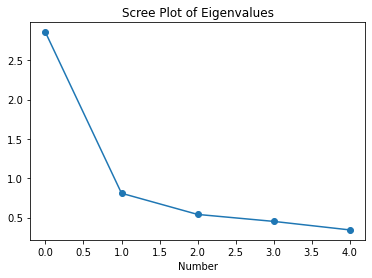

In [10]:
#(b) How many factors are required to describe adequately the space in which these data actually fall?
#scree plot
plt.title('Scree Plot of Eigenvalues')
plt.xlabel('Number')
plt.plot(eigval, 'o-')
plt.show()

In [11]:
#(c) Obtain the factor loading matrix using Principal Component method.
loadings = pd.DataFrame()
loadings['Factor1'] = np.sqrt(eigval[0])*eigvec[:,0]
loadings.index = stock.columns
np.round(loadings,2)

,Factor1
AC,0.78
DP,0.77
UC,0.79
EX,0.71
TX,0.71


In [12]:
#(d) Obtain the communality of each variable
loadsquare = loadings**2
pd.DataFrame(loadsquare.sum(axis=1), columns = ['Communality'])

,Communality
AC,0.613773
DP,0.596774
UC,0.630945
EX,0.507916
TX,0.507079


In [13]:
#(f) Obtain factor (before rotation) loading matrix using Minres method.
from factor_analyzer import FactorAnalyzer

In [14]:
fa = FactorAnalyzer(n_factors=2, rotation=None, method='minres', is_corr_matrix=True)
fa.fit(data)

FactorAnalyzer(is_corr_matrix=True, n_factors=2, rotation=None,
               rotation_kwargs={})

In [15]:
#Factor loadings before rotation
loadings = pd.DataFrame(fa.loadings_, 
                        index = stock.columns, 
                        columns = ['Factor1', 'Factor2'])
loadings

,Factor1,Factor2
AC,0.696010,-0.096709
DP,0.758582,-0.418575
UC,0.715361,-0.146355
EX,0.606299,0.156562
TX,0.723501,0.545413


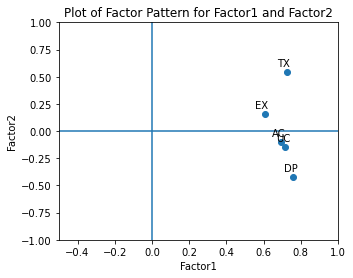

In [16]:
#Preplot(Before Rotation)
x = loadings.Factor1 ; y = loadings.Factor2
plt.figure(figsize = (5,4))
plt.title('Plot of Factor Pattern for Factor1 and Factor2')
plt.xlabel('Factor1') ; plt.ylabel('Factor2')
plt.scatter(x,y)
for i in range(len(loadings)):
    plt.text(x[i]-0.05, y[i]+0.05, loadings.index[i])
plt.axvline(x = 0) ; plt.axhline(y = 0) 
plt.xlim(-0.5,1); plt.ylim(-1,1)
plt.show()

In [17]:
#(g) Obtain factor (after rotation) loading matrix using Minres method.
# Rotation Method: Varimax
fa = FactorAnalyzer(n_factors=2, rotation='varimax', method='minres', is_corr_matrix=True)
fa.fit(data)

FactorAnalyzer(is_corr_matrix=True, n_factors=2, rotation='varimax',
               rotation_kwargs={})

In [18]:
# Orthogonal Transformation Matrix
fa.rotation_matrix_

array([[ 0.76844413,  0.63991689],
       [-0.63991689,  0.76844413]])

In [19]:
# Rotated Factor Pattern
Rloadings = pd.DataFrame(fa.loadings_, 
             index = stock.columns, 
             columns = ['Factor1', 'Factor2'])
Rloadings

,Factor1,Factor2
AC,0.596731,0.371073
DP,0.850781,0.163778
UC,0.643369,0.345306
EX,0.365720,0.508290
TX,0.206951,0.882100


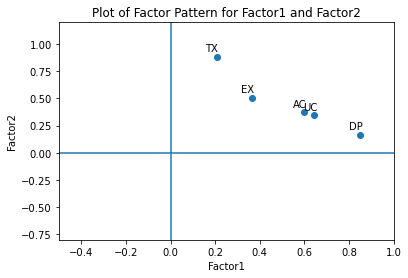

In [20]:
#Plot(After Rotation)
x = Rloadings.Factor1 ; y = Rloadings.Factor2
plt.figure(figsize = (6,4))
plt.title('Plot of Factor Pattern for Factor1 and Factor2')
plt.xlabel('Factor1') ; plt.ylabel('Factor2')
plt.scatter(x,y)
for i in range(len(loadings)):
    plt.text(x[i]-0.05, y[i]+0.05, Rloadings.index[i])
plt.axvline(x = 0) ; plt.axhline(y = 0) 
plt.xlim(-0.5,1); plt.ylim(-0.8,1.2)
plt.show()

In [21]:
#(h) Obtain the communalities (after rotation) of each variable.
pd.DataFrame(fa.get_communalities(), 
             index=stock.columns, 
             columns=['Communality'])

,Communality
AC,0.493783
DP,0.750651
UC,0.533161
EX,0.392110
TX,0.820929
